<a id="title_ID"></a>
# JWST Pipeline Validation Notebook: 
# Calwebb_coron3 for MIRI coronagraphic imaging

### Table of Contents

<br> [Introduction](#intro)
<br> [JWST CalWG Algorithm](#algorithm)
<br> [Defining Terms](#terms)
<br> [Test Description](#test_descr)
<br> [Data Description](#data_descr)
<br> [Imports](#imports)
<br> [Load Input Data](#data_load)
<br> [Run the Pipeline](#run_pipeline)
<br> [Examine Outputs](#output) 
<br> [About This Notebook](#about)



<a id="intro"></a>
# Introduction

This is a tutorial notebook for processing MIRISim coronagraphic data through the JWST calibration pipeline. 

- Module descriptions:
  - Stage 1 (Detector artifacts) https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html
  - Stage 2 (Image calibration) https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html 
  - Stage 3 (Coronagraph) https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_coron3.html

- Pipeline code: https://github.com/spacetelescope/jwst/blob/master/jwst/coron/


[Top of Page](#title_ID)

<a id="stage_3_algorithm"></a>
# JWST Stage3 Algorithm


The algorithms for `CALWEBB_CORON3` are as follows:

- **Assemble Reference PSFs**: <br>
All the available reference PSFs are assembled into the appropriate association.


- **Outlier detection**: <br> 
An iterative sigma clipping algorithm is used in pixel coordinates on the image stack. The presence of an outlier results in a pixel flag being set.


- **Align reference PSFs**: <br>
The reference PSFs are aligned with the target observation using the Fourier LSQ algorithm to measure the shifts and the Fourier Shift algorithm to apply the shifts to each reference PSF integration.


- **Reference PSF subtraction**: <br>
The reference PSF that is subtracted from each target integration is created using the list of reference PSFs and the KLIP algorithm. 


- **Image Combination**: <br>
The target images (including those at different rotations) are combined into a single combined image using the AstroDrizzle code (with the output pixel size set to the input pixel size).


- **Updated Exposure Level Products**: <br>
The exposure level products are re-created to provide the highest quality products that include the results of the ensemble processing (updated WCS, matching backgrounds, and 2nd pass outlier detection). 

<BR>

The current status of these algorithms are summarized in the link below:

> https://outerspace.stsci.edu/display/JWSTCC/CALWEBB_CORON3


[Top of Page](#title_ID)

<a id="terms"></a>
# Defining Terms

- **JWST**: James Webb Space Telescope ([see documentation](https://jwst-docs.stsci.edu/))
- **MIRI**: Mid-Infrared Instrument ([see documentation](https://jwst-docs.stsci.edu/mid-infrared-instrument))
- **4QPM**: 4 Quadrant Phase Mask ([see documentation](https://jwst-docs.stsci.edu/mid-infrared-instrument/miri-instrumentation/miri-coronagraphs#MIRICoronagraphs-4qpm))
- **Lyot**: coronagraph design incorporating a classical Lyot spot ([see documentation](https://jwst-docs.stsci.edu/mid-infrared-instrument/miri-instrumentation/miri-coronagraphs#MIRICoronagraphs-lyotcoron))
    
 [Top of Page](#title_ID)

<a id="data_descr"></a>
# Data Description

### Input Data:

For Stage 3 processing, the data set must contain both science exposures and PSF references. These can be demarcated however you like, and may even have the same file name as long as they have different paths. For MIRISim data this is often the case; however, for the purposes of this tutorial, the data at have all been collected in the same folder and given unique names. The simulated exposures are available here:
> https://stsci.box.com/s/tk52601kge1rhhcim9kf1al0x2bee4s3

The data have the following naming format:
- Science exposures: 
    - `Vega-det_image_seq1_MIRIMAGE_F1550Cexp1-roll1.fits`
    - `Vega-det_image_seq1_MIRIMAGE_F1550Cexp1-roll2.fits`
    
- Reference PSF exposures:
    - `piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-0.fits`
    - `piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-1.fits`
    - `piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-2.fits`
    - `piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-3.fits`
    - `piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-4.fits`
    - `piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-5.fits`
    - `piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-6.fits`
    - `piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-7.fits`
    - `piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-8.fits`
    
      


### Reference Files:

The `align_refs` step requires a PSFMASK reference file containing a 2D mask that’s used as a weight function when computing shifts between images. 

> File description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/align_refs/description.html#psfmask-reffile

Currently the PSFMASK reference files ingested into CRDS are incorrect (wrong shape and incorrectly centered around coronagraphic obstructions), therefore an updated file is used for these tests:

> https://github.com/STScI-MIRI/Gen_PSFMASK_ref_files/tree/main/psf_masks_new

Choose the file associated with the coronagraphic filter that matches your data.
 

### Association File:

Currently the individual stage 3 coronagraphic processing steps can only be run in a convenient way by running the `calwebb_coron3` pipeline on an association (ASN) file that lists the various science target and reference PSF exposures to be processed. 

> Level 3 Associations documentation: https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level3_asn_rules.html

Normally an association file would be generated automatically and provided along with the data, but in this case we will generate an association file for this step.




[Top of Page](#title_ID)

<a id="imports_ID"></a>
# Imports

* `astropy.io` for opening fits files
* `jwst` is the JWST Calibration Pipeline
* `jwst.Coron3Pipeline` is the pipeline being tested
* `matplotlib` and `matplotlib.pyplot` to generate plots
* `numpy` for array calculations and manipulation
* `asn_from_list` for generating Stage 3 coronagraph association files (not used in this tutorial, but it's an option)

[Top of Page](#title_ID)

In [2]:
from astropy.io import fits
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.close_figures=False # To prevent automatic figure display when execution of the cell ends
import numpy as np

import jwst
from jwst.pipeline import Detector1Pipeline, Image2Pipeline, Coron3Pipeline
from jwst.associations.asn_from_list import asn_from_list

2021-11-15 21:38:00,257 - stpipe - WARNING - /Users/jaguilar/Projects/miniconda3/envs/jwst/lib/python3.9/site-packages/photutils/detection/findstars.py:33: AstropyDeprecationWarning: _StarFinderKernel was moved to the photutils.detection._utils module. Please update your import statement.
  warnings.warn(f'{name} was moved to the {deprecated[name]} module. '



In [3]:
jwst.__version__
# should be '1.3.3'

'1.1.0'

### Detector1Pipeline

<a id="data_load"></a>
# Load Input Data

I like to use a dictionary to keep track of my file paths because the dictionary key can be used to store file metadata, like if it's a science target or a reference image. In the cell below, I collect my files together and assign them the appropriate keys.

In [4]:
from pathlib import Path
data_files = {
    # science targets
    'roll1': Path("data/Vega-det_image_seq1_MIRIMAGE_F1550Cexp1-roll1.fits"),
    'roll2': Path("data/Vega-det_image_seq1_MIRIMAGE_F1550Cexp1-roll2.fits")
}
# reference targets
psf_path = Path("data")
data_files.update(
    {'psf'+p.stem[-1]: p for p in sorted(psf_path.glob("piHer*fits"))}
                 )

In [5]:
data_files

{'roll1': PosixPath('data/Vega-det_image_seq1_MIRIMAGE_F1550Cexp1-roll1.fits'),
 'roll2': PosixPath('data/Vega-det_image_seq1_MIRIMAGE_F1550Cexp1-roll2.fits'),
 'psf0': PosixPath('data/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-0.fits'),
 'psf1': PosixPath('data/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-1.fits'),
 'psf2': PosixPath('data/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-2.fits'),
 'psf3': PosixPath('data/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-3.fits'),
 'psf4': PosixPath('data/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-4.fits'),
 'psf5': PosixPath('data/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-5.fits'),
 'psf6': PosixPath('data/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-6.fits'),
 'psf7': PosixPath('data/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-7.fits'),
 'psf8': PosixPath('data/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-8.fits')}

In [5]:
# Make sure the CORONMSK header is set correctly; MIRISim misses this sometimes (n.b. this has been fixed in the latest version, once I confirm this with a new simulation I will remove this cell)
for k, data_file in data_files.items():
    try:
        fits.getval(data_file, 'CORONMSK', ext=0)
    except KeyError:
        print("CORONMSK not found, writing to header")
        fits.setval(data_file, keyword="CORONMSK", value="4QPM_1550", ext=0, comment="Coronagraphic mask", savecomment=False)

[Top of Page](#title_ID)
<a id="run_pipeline"></a>


------------
# Run the Pipeline

In this tutorial, we have the choice to use configuration files to explicitly set all parameters, as an example for the user. In actual practice, all parameters will at least take the default value unless otherwise specified. The upshot of this is that the user should *only* provide parameters that they wish to change from the default. In general, the pipeline default values are chosen to provide the optimal output for properly calibrated science products. By only providing values for parameters that they explicitly wish to change, users will prevent themselves from unintentionally overriding the default pipeline parameters in the case of a pipeline update where the default values are changed. 

## Universal parameters
You can pass these parameters to any pipeline stage or step.
- Save results
    - `save_results=[bool]`
    - if True, save the results to a file specified by `output_dir` and `output_file` (uses defaults if none specified)
- Output directory
    - `output_dir=[path]`
    - directory where output files will be written
- Output file prefix
    - `output_file=[basename]`
    - file prefix for output files
- Reference file override
    - `override_<ref_type>=[path to reference file to use instead`
    - use the provided reference file instead of the one automatically selected by CRDS
    - `<ref_type>` is the name of the reference file type in lowercase, e.g. `dark`, `mask`, `gain`, `linearity`, `psfmask`
- Skip
    - `skip=[bool]`
    - skip a step if you want; the output of the previous step will be provided to the input of the following step
- Logging configuration file
    - `logcfg=[log config file name]`
    - specify where to place the log and the level of detail to record
    - see https://jwst-pipeline.readthedocs.io/en/latest/jwst/introduction.html#logging-configuration for formatting
    
Additionall, the `Detector1Pipeline`, `Image2Pipeline`, and `Coron3Pipeline` classes can accept the `steps` argument to pass step-specific arguments to a specified step. This takes a dictionary with the following structure:

    step_args = {
                 'step1_name': {arg: val}, 
                 'step2_name': {arg1: val1, arg2: val2}
                }

    
The following parameters are technically available but should *not* be included by users in a parameter reference, as per https://jwst-pipeline.readthedocs.io/en/latest/jwst/stpipe/config_asdf.html?highlight=output_ext#jwst-parameters-and-parameter-references:
- `input_dir`
- `output_ext`
- `output_use_index`
    - cannot find documentation
- `output_use_model`
    - True to always base output file names on the DataModel.meta.filename of the DataModel being saved
- `pre_hooks`
    - command-line hooks to run just before a step
    - uses same input as parent step
- `post_hooks`
    - command-line hooks to run just after a step
    - uses same input as parent step
- `save_results`
- `search_output_file`
    - True to retrieve the output_file from a parent Step or Pipeline


## Parameter files

You can pass parameters through the class interface (`.run()` or `.call()`), or you can place them in a parameter file. There are three parameter files for each stage of the pipeline in the `parameter_files` subfolder - one with all the parameters, one with only the parameters that are unique to each stage and/or step, and one that only includes modified arguments for use during these examples.

In [6]:
# Let's generate and save the stage parameter files with their default values. Then, you can edit them as you please
if False: # set to True to regenerate config files
    Detector1Pipeline().export_config("parameter_files/stage1_parameters.asdf")
    Image2Pipeline().export_config("parameter_files/stage2_parameters.asdf")
    Coron3Pipeline().export_config("parameter_files/stage3_parameters.asdf")

In [7]:
# You can also get the parameters as a dictionary object
if False: # set to True to create these dictionaries
    stage_1_pars = Detector1Pipeline().get_pars()
    stage_2_pars = Image2Pipeline().get_pars()
    stage_3_pars = Coron3Pipeline().get_pars()

#  Stage 1: Detector effects correction

Class name: `Detector1Pipeline`

> https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html

Stage 1 consists of detector-level corrections that are performed on a group-by-group basis, followed by ramp fitting. The output of stage 1 processing is a countrate image per exposure, or per integration for some modes.


It uses the following parameters, in addition to the universal parameters:
- `save_calibrated_ramp`
    - takes bool `[False]`
    - if True, save intermediate data to a file as it exists after the `jump` step and before the `ramp_fit` step

The steps (in order of execution, I think) are:
- `group_scale`
    - group scale correction; 
    - rescales pixel values in raw JWST science data products to correct for instances where on-board frame averaging didn't result in the proper downlinked values
    - no step-specific arguments
    - does not use any reference files
- `dq_init`
    - data quality initialization
    - populates the DQ mask for the input dataset
    - no step-specific arguments
    - reference file: MASK
- `saturation`
    - flags pixels at or below the A/D floor (< 0 DN) or above the saturation threshold
    - no step-specific arguments
    - reference file: SATURATION
- `ipc`
    - interpixel capacitance 
    - corrects for ipc by convolving with an IPC reference image
    - no step-specific arguments
    - reference file: IPC
- `firstframe`
    - only for MIRI; flags the first group in every integration as bad (sets DO_NOT_USE DQ bit)
    - no step-specific arguments
    - no reference file used
- `lastframe`
    - only for MIRI; flags the final group in each integration as bad (sets DO_NOT_USE DQ bit)
    - no step-specific arguments
    - no reference file used
- `linearity`
    - linearity correction
    - correction is applied pixel-by-pixel, group-by-group, integration-by-integration within a science exposure
    - no step-specific arguments
    - reference file: LINEARITY
- `rscd`
    - Reset Switch Charge Decay (RSCD) Correction
    - only for MIRI, and only applied after the first integration
    - flags N groups as DO_NOT_USE if the charge in the reset switches has not sufficienty decayed?
    - no step-specific arguments
    - reference file: RSCD    
- `dark_current`
    - dark current subtraction
    - subtracts dark current data stored in a dark reference file
    - one step-specific argument:
        - `dark_output filename`; saves the frame-averaged dark data to this file
    - reference file: DARK    
- `refpix`
    - reference pixel correction
    - uses reference pixels to correct for drifts in the readout amplifiers
    - step arguments:
        - `odd_even_columns bool [True]`; odd and even columns are treated separately
        - `use_side_ref_pixels bool [True]`; only for NIR data
        - `side_smoothing_length int [11]`: height of the window used for the running median calculation
        - `side_gain float [1.0]` how much to multiply the side reference signal before subtraction
        - `odd_even_rows bool [True]` calculate reference signal separately for odd and even rows; only for MIR
    - reference file: DARK    
- `jump`
    - detects jumps in an exposure (after saturation step has been applied)
    - looks for outliers in up-the-ramp read
    - skips automatically if ngroups/integration < 3
    - step-specific arguments:
        - `rejection_threshold float [4.0]` sigma rejection threshold
        - `maximum_cores string [none]` fraction of available cores to use
        - `flag_4_neighbors bool [True]` if jump is detected, flag 4 neighbors as jumps too
        - `max_jump_to_flag_neighbors float [200]` sigma threshold to limit automatic neighbor flagging (so they will be flagged as primary jumps, and *their* neighbors can be flagged
        - `min_jump_to_flag_naighbors float [10]` limits flagging of neighbors of marginal jump detections.
    - two reference files:
        - GAIN
        - READNOISE
- `ramp_fitting`
    - fits a line to the group data in the input file to determine the count rate
    - step-specific arguments:
        - `save_opt bool [False]` write optional output product
        - `opt_name str` overrides the default name for the output product
        - `int_name str` overrides the default name for the per-integration product
        - `maximum_cores str [none]` fraction of cores to use for multiprocessing
    - reference files: 
        - GAIN
        - READNOISE
- `gain_scale`
    - rescales pixel values in countrate science data products to correct for the effect of using a non-standard detector gain setting
    - makes them appear as if standard gain setting had been used
    - currently only for NIRSPEC
    - no step-specific arguments
    - reference file: GAIN

OK, let's assemble a dictionary of arguments for Stage 1. We want to change the output directory, and we want to save the frame-averaged dark data to the file `{output_directory}/stage1_dark_current.fits`. 
To generate a config file template, use `<stage_class>.export_config("filename")`.

In [8]:
# this dictionary is equivalent to the stage1_parameters-example.asdf file
stage1_args = {'output_dir': "output_stage1", 
               'save_results': True, 
               'steps': {
                   'dark_current': {'output_file': 'stage1_dark_current'},
               }
              }

In [10]:
# Run Stage 1
if True: # set to True to run or False to use the pre-existing Stage 1 data products, if you have already run the pipeline
    for data_file in sorted(data_files.values()):
        print(data_file)
        # the following cases are equivalent; switch by choosing one case to be True
        if True:
            print("Config file")
            det1 = Detector1Pipeline.call(str(data_file), config_file='./parameter_files/stage1_parameters-example.asdf')
        elif False:
            print("Dictionary")
             # split off the step-specific parameters from the top-level parameters
            #step_args = stage1_args.pop('steps')
            det1 = Detector1Pipeline.call(str(data_file), **stage1_args)        
        elif False:
            print("Object attributes")
            # you can also create a Pipeline class instance and set its properties directly:
            det1 = Detector1Pipeline()
            det1.save_results = True
            det1.output_dir = './output_stage1/'
            det1.dark_current.output_file = 'stage1_dark_current'
            det1.run(str(data_file))
        else:
            pass
        print(det1)


In [18]:
# gather a list of the Stage 1 data products
stage1_products = sorted(Path("output_stage1").glob("*rateints.fits"))
print("Here are the Stage 1 data products:\n")
print("\n".join(str(i) for i in list(stage1_products)))

Here are the Stage 1 data products:

output_stage1/Vega-det_image_seq1_MIRIMAGE_F1550Cexp1-roll1_rateints.fits
output_stage1/Vega-det_image_seq1_MIRIMAGE_F1550Cexp1-roll2_rateints.fits
output_stage1/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-0_rateints.fits
output_stage1/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-1_rateints.fits
output_stage1/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-2_rateints.fits
output_stage1/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-3_rateints.fits
output_stage1/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-4_rateints.fits
output_stage1/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-5_rateints.fits
output_stage1/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-6_rateints.fits
output_stage1/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-7_rateints.fits
output_stage1/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-8_rateints.fits


# Stage 2: Image calibration

Stage name: `Image2Pipeline`
> https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html 

Stage 2 imaging processing applies additional instrumental corrections and calibrations that result in a fully calibrated individual exposure.

It uses the following custom arguments, in addtion to the universasl arguments:
- `save_bsub bool [False]`
	- if True, save the results of the background subtraction step to an intermediate file, with product type _bsub or _bsubints depending on if you want to preserve the individual integrations in a 3D datacube
    

The steps are:
- `bkg_subtract`
	- subtracts background signal using image-from-image subtraction. Input is a target exposure and one or more background exposures. 
	- Other methods of background subtraction are available (see here). 
	- step-specific arguments:
		- sigma float [3] number of standard deviations to use for sigma-clipped background computation
		- maxiters int [None] number of clipping iterations to perform, None causes algorithm to iterate until convergence
		- save_combined_background bool [False] if True, saves the background image 
	- reference files: only used when processing wide-field slitless spectroscopy exposures (so, not used for coronagraphy)
- `assign_wcs`
	- Associates a WCS object with each science exposure, transforming positionsin the detector frame to positions in a world coordinate frame (ICRS and wavelength).
	- WCS is saved in the ASDF extension of the fits file, and can be accessed as an attribute of the meta object when the fits file is opened as a data model
	- No step-specific arguments
		-     sip_approx: true
		-     sip_max_inv_pix_error: 0.25
		-     sip_max_pix_error: 0.25
		-     sip_npoints: 32
		-     slit_y_high: 0.55
		-     slit_y_low: -0.55
	- reference files: the reference file types used by MIRI are:
		- DISTORTION
		- FILTEROFFSET
		- SPECWCS
		- REGIONS
		- WAVELENGTHRANGE
		- I think only DISTORTION and FILTEROFFSET are used by the coronagraphs
- `flat_field`
	- At its basic level this step flat-fields an input science dataset by dividing by a flat-field reference image. In particular, the SCI array from the flat-field reference file is divided into the SCI array of the science dataset, the flat-field DQ array is combined with the science DQ array using a bitwise OR operation, and variance and error arrays in the science dataset are updated to include the flat-field uncertainty.
	- No step-specific arguments  for MIRI (there is one for NIRSpec)
	- Reference files types: 
		- FLAT - contains pixel-by-pixel detector response values
- `photom`
	- applies flux (photometric) calibrations to a data product to convert the data from units of countrate to surface brightness (or, in some cases described below, to units of flux density). The calibration information is read from a photometric reference file. The exact nature of the calibration information loaded from the reference file and applied to the science data depends on the instrument mode
	- no step-specific arguments
	- reference file types:
		- PHOTOM - conversion factors for putting pixel values into physical units
		- AREA - pixel area information for a given instrument mode.
- `resample`
	- resample each input 2D image based on the WCS and distortion information, and will combine multiple resampled images into a single undistorted product
	- Data products (ending in _i2d ) are only intended for quicklook and are not passed on to Stage 3
	- step-specific arguments
		- pixfrac float [1.0] fraction by which input pixels are “shrunk” before being drizzled
		- kernel str ['square'] The form of the kernel function used to distribute flux onto the output image
		- blendheaders bool [True] Blend metadata from all input images into the resampled output image.
		- pixel_scale_ratio float [1.0] Ratio of input to output pixel scale
		- fillval str ['INDEF'] The value to assign to output pixels that have zero weight or do not receive any flux from any input pixels during drizzling.
		- weight_type str ['ivm'] The weighting type for each input image
		- single bool [False] resample each input image into a separate output
	- reference file types: DRIZPARS

In [19]:
# this dictionary is equivalent to the stage2_parameters-example.asdf file
stage2_args = {'output_dir': "./output_stage2/", 
               'save_results': True, 
               'save_bsub': True,
               'steps': {
                   'bkg_subtract': {'save_combined_background': True},
               }
              }

In [21]:
# now, run Stage 2 on each of the Stage 1 data products
if True: # set to True to run, or False if you already have Stage 2 products you want to use
    for filename in stage1_products:
        # set one of the following equivalent cases to True to run it
        if False:
            print("Config file")
            img2 = Image2Pipeline.call(str(filename), config_file='./parameter_files/stage2_parameters-example.asdf')
        elif True:
            print("Dictionary")
            img2 = Image2Pipeline.call(str(filename), **stage2_args)
        else:
            pass
        print(img2)

In [25]:
stage2_products = sorted(Path("output_stage2").glob("*calints.fits"))
print("Here are the Stage 2 data products:\n")
print("\n".join(str(i) for i in list(stage2_products)))

Here are the Stage 2 data products:

output_stage2/Vega-det_image_seq1_MIRIMAGE_F1550Cexp1-roll1_calints.fits
output_stage2/Vega-det_image_seq1_MIRIMAGE_F1550Cexp1-roll2_calints.fits
output_stage2/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-0_calints.fits
output_stage2/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-1_calints.fits
output_stage2/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-2_calints.fits
output_stage2/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-3_calints.fits
output_stage2/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-4_calints.fits
output_stage2/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-5_calints.fits
output_stage2/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-6_calints.fits
output_stage2/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-7_calints.fits
output_stage2/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-8_calints.fits


# Stage 3: PSF subtraction

Stage name: `Coron3Pipeline`

> https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_coron3.html#calwebb-coron3


Stage 3 processing is used to produce PSF-subtracted, resampled, combined images of the source object.

Stage 3 has no top-level custom arguments, aside from the universal arguments.

Stage 3 steps and their custom arguments:

- `outlier_detection`
	- More sensitive to cosmics, bad pixels, and other outliers than at the jump step
	- step-specific arguments
		- `weight_type (string, default=’exptime’)` The type of data weighting to use during resampling; options are ‘exptime’, ‘error’, and ‘None’.
		- `pixfrac (float, default=1.0)` The pixel fraction used during resampling; valid values go from 0.0 to 1.0.
		- `kernel (string, default=’square’)` The form of the kernel function used to distribute flux onto a resampled image. Options are ‘square’, ‘turbo’, ‘point’, ‘lanczos’, and ‘tophat’.
		- `fillval (string, default=’INDEF’)` The value to assign to resampled image pixels that have zero weight or do not receive any flux from any input pixels during drizzling. Any floating-point value, given as a string, is valid. A value of ‘INDEF’ will use the last zero weight flux.
		- `nlow (integer, default=0)` The number of low values in each pixel stack to ignore when computing the median value.
		- `nhigh (integer, default=0)` The number of high values in each pixel stack to ignore when computing the median value.
		- `maskpt (float, default=0.7)` The percent of maximum weight to use as lower-limit for valid data; valid values go from 0.0 to 1.0.
		- `grow (integer, default=1)` The radius, in pixels, from a bad pixel for neighbor rejection.
		- `snr (string, default=’4.0 3.0’)` The signal-to-noise values to use for bad pixel identification. Valid values are a pair of floating-point values in a single string.
		- `scale (string, default=’0.5 0.4’)` The scaling factor applied to derivative used to identify bad pixels. Valid values are a pair of floating-point values in a single string.
		- `backg (float, default=0.0)` User-specified background value to apply to the median image.
		- `save_intermediate_results (boolean, default=False)` Specifies whether or not to save any intermediate products created during step processing.
		- `resample_data (boolean, default=True)` Specifies whether or not to resample the input images when performing outlier detection.
		- `good_bits (string, default=”~DO_NOT_USE”)` The DQ bit values from the input image DQ arrays that should be considered ‘good’ when building the weight mask. See DQ flag Parameter Specification for details.
		- `scale_detection (bool, default=False)` Specifies whether or not to rescale the individual input images to match total signal when doing comparisons.
		- `allowed_memory (float, default=None)` Specifies the fractional amount of free memory to allow when creating the resampled image
	- reference file types: no reference files used
- `stack_refs`
	- It takes a list of reference PSF products and stacks all of the per-integration images contained in each PSF product into a single 3D data cube.  The image data are simply copied and reformatted, without being modified in any way.
	- step-specific arguments: none
	- reference file types: no reference files used
- `align_refs`
	- It computes offsets between science target images and reference PSF images, and shifts the PSF images into alignment.
	- step-specific arguments
		- median_box_length (integer, default=3) The box size to use when replacing bad pixels with the median in a surrounding box.
		- bad_bits (string, default=”DO_NOT_USE”)The DQ bit values from the input image DQ arrays that should be considered bad and replaced with the median in a surrounding box.
	- reference file types: PSFMASK
- `klip`
	- It applies the Karhunen-Loeve Image Plane (KLIP) algorithm to coronagraphic images, using an accompanying set of reference PSF images, in order to fit and subtract an optimal PSF from a source image
	- step-specific arguments
		- truncate (integer, 50) This is an integer parameter with a default value of 50 and is used to specify the number of KL transform rows to keep when computing the PSF fit to the target.
	- reference file types: none
- `resample`
	- This routine will resample each input 2D image based on the WCS and distortion information, and will combine multiple resampled images into a single undistorted product.
	- step-specific arguments: same as for Stage 2
	- reference file types: DRIZPARS

## Running Stage 3

To perform PSF subtraction, you have to tell Stage 3 which exposures are science targets and which are PSF references. This is done with an "association file", which is documented briefly here https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_coron3.html. In the example below, we will use our pre-defined file names to split the exposures into the appropriate categories and generate an association file in JSON format.

In [26]:
import json

In [1]:
output_path = Path("output_stage3")
asn_file = Path("stage3_asn.json")                       # Define ASN file

# make sure you have the right paths
assert(output_path.exists())


# You need an association file. Generate and write it to disk. YAML format is acceptable
# target files
target_files = [f for f in stage2_products if f.name.find('roll') >= 0]
reference_files = [f for f in stage2_products if f.name.find('roll') < 0]

# Most of the preamble stuff doesn't matter, and in practice will be set automatically by the pipeline
# `name` determines the file prefixes
asn = {
    # preamble
    "asn_type": "coron3",
    "asn_rule": "candidate_Asn_Coron",
    "program": "mirisim jwst tutorial",
    "asn_id": "c1001",
    "target": "tutorial",
    "asn_pool": f"tutorial-pool",
    # exposure definitions
    "products": [
        {"name": f"mirisim_jwst_tutorial",
             # 'members' takes a list of dictionaries that associate an exposure type with a file name
             "members": [{'expname': str(ff), 'exptype': 'science'} for ff in target_files] +\
                        [{'expname': str(ff), 'exptype': 'psf'} for ff in reference_files], 

        }
    ]
}

with open(str(asn_file), "w") as outfile:
    json.dump(asn, outfile)
    #yaml.dump(asn, outfile)

assert(asn_file.exists())

NameError: name 'Path' is not defined

As described earlier, for the moment we need to override the default PSFMASK reference files and provide our own. 
The masks can be found here: https://github.com/STScI-MIRI/Gen_PSFMASK_ref_files/tree/main/psf_masks_new
- `*0001.fits`: 1065
- `*0002.fits`: 1550
- `*0003.fits`: 1140
- `*0004.fits`: LYOT
  
(n.b. yes 0002 and 0003 are really out of wavelength order, this is being corrected)

Since we simulated the 1550 4QPM, we choose the appropriate PSFMASK file in the dictionaries below. Once the PSFMASK files in CRDS are corrected, this will be done automatically based on the Stage 2 data product header keywords.

In [28]:
psfmask_files = {"1065": "./psfmasks/jwst_miri_psfmask_0001.fits",
                 "1140": "./psfmasks/jwst_miri_psfmask_0003.fits",
                 "1550": "./psfmasks/jwst_miri_psfmask_0002.fits",
                 "LYOT": "./psfmasks/jwst_miri_psfmask_0004.fits"}
stage3_params = {"save_results": True,
                 "output_dir": "output_stage3",
                 "steps": {
                     "align_refs": {"override_psfmask": psfmask_files["1550"]}
                 }
                }

Now, all that's left is to run the pipeline!

In [29]:
if True:
    # run the pipeline
    if True:
        cor3 = Coron3Pipeline.call(str(asn_file), config_file='./parameter_files/stage3_parameters-example.asdf')                              
    else:
        cor3 = Coron3Pipeline.call(str(asn_file), **stage3_params)

    print(f"\n\nFinished\n\n")

In [31]:
stage3_products = sorted(Path("output_stage3").glob("*.fits"))
print("Here are the Stage 3 data products:\n")
print("\n".join(str(i) for i in list(stage3_products)))

Here are the Stage 3 data products:

output_stage3/Vega-det_image_seq1_MIRIMAGE_F1550Cexp1-roll1_c1001_crfints.fits
output_stage3/Vega-det_image_seq1_MIRIMAGE_F1550Cexp1-roll1_c1001_psfalign.fits
output_stage3/Vega-det_image_seq1_MIRIMAGE_F1550Cexp1-roll1_c1001_psfsub.fits
output_stage3/mirisim_jwst_tutorial_i2d.fits
output_stage3/mirisim_jwst_tutorial_psfstack.fits
output_stage3/piHer-det_image_seq1_MIRIMAGE_F1550Cexp1-0_c1001_crfints.fits


The step that takes the longest is the reference image alignment ("`align_refs`"). As an exercise to the user, see if you can find the flag to save the alignment products to the Stage 3 output folder, and then to read them back in for subsequent Stage 3 runs.

[Top of Page](#title_ID)
<a id="output"></a>
--------------
# Output products

- `_crfints.fits` : cosmics and outliers removed bu `outlier_detection` step
- `_psfstack.fits` : all the reference exposures, concatenated into a single cube by the `stack_refs` step
- `_psfalign.fits` : for each science target exposure, all the slices of the `psfstack` product are aligned to each science target *integration* by the `align_refs` step and saved as a 4D cube
- `_psfsub.fits` : for each science target exposure, KLthe `klip` step generates a model PSF for each integration and subtracts it off, resulting in a 3D cube
- `_i2d.fits` : The `resample` step is applied to the CR-flagged products to create a single resampled and combined product for the science targethe resample step is applied to the CR-flagged products to create a single resampled and combined product for the science targethe resample step is applied to the CR-flagged products to create a single resampled and combined product for the science target

<a id="stack_refs"></a>
###  `stack_refs`:  Stack PSF References (*'_psfstack' product*)

The role of the `stack_refs` step is to stack all of the PSF reference exposures (specified in the input ASN file) into a single `CubeModel` for use by subsequent coronagraphic steps. The size of the stack should be equal to the sum of the number of integrations in each input PSF exposure.  The image data are simply copied and reformatted and should not be modified in any way.

*Output*: **3D PSF Image Stack** <br>
*File suffix*: **'_psfstack'**

> Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/stack_refs/index.html#stack-refs-step

In [32]:
from IPython.display import display,clear_output

In [33]:
stacked_cube_hdu = fits.open('output_stage3/mirisim_jwst_tutorial_psfstack.fits')
ref_images = stacked_cube_hdu[1].data
print(stacked_cube_hdu.info())

Filename: output_stage3/mirisim_jwst_tutorial_psfstack.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     221   ()      
  1  SCI           1 ImageHDU        68   (288, 224, 16)   float32   
  2  ERR           1 ImageHDU        11   (288, 224, 16)   float32   
  3  DQ            1 ImageHDU        12   (288, 224, 16)   int32 (rescales to uint32)   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5572B]   
None


In [34]:
print("'_psfstack' data product dimensions: "+str(ref_images.shape))

'_psfstack' data product dimensions: (16, 224, 288)


------------
<a id="klip"></a>
### `klip`:  Reference PSF Subtraction

The role of the `klip` step is to apply the Karhunen-Loeve Image Plane (KLIP) algorithm on the science target images, using an accompanying set of aligned reference PSF images (result of the `align_refs` step) in order to fit and subtract an optimal PSF from the science target image. The PSF fitting and subtraction is applied to each integration image independently. The output is a 3D stack of PSF-subtracted images of the science target, having the same dimensions as the input science target product.

*Output*: **3D PSF-subtracted image** <br>
*File suffix*: **_psfsub**

> Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/klip/index.html#klip-step


In [35]:
sub_hdu = fits.open('output_stage3/Vega-det_image_seq1_MIRIMAGE_F1550Cexp1-roll1_c1001_psfsub.fits')
sub_hdu.info()

Filename: output_stage3/Vega-det_image_seq1_MIRIMAGE_F1550Cexp1-roll1_c1001_psfsub.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     226   ()      
  1  SCI           1 ImageHDU        68   (288, 224, 75)   float32   
  2  ERR           1 ImageHDU        11   (288, 224, 75)   float32   
  3  DQ            1 ImageHDU        12   (288, 224, 75)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (288, 224, 75)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (288, 224, 75)   float32   
  7  VAR_FLAT      1 ImageHDU        10   (288, 224, 75)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [22239B]   


In [36]:
subtracted_image = sub_hdu[1].data
print("Science target image dimensions: " + str(subtracted_image.shape))
print("PSF subtracted image dimensions: " + str(subtracted_image.shape))

Science target image dimensions: (75, 224, 288)
PSF subtracted image dimensions: (75, 224, 288)


Note that the PSF subtracted image has the same dimensions as the input target image.

2021-11-05 13:04:23,880 - stpipe - WARNING - <ipython-input-37-6c0ff62d821e>:13: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm=mpl.colors.SymLogNorm(1),



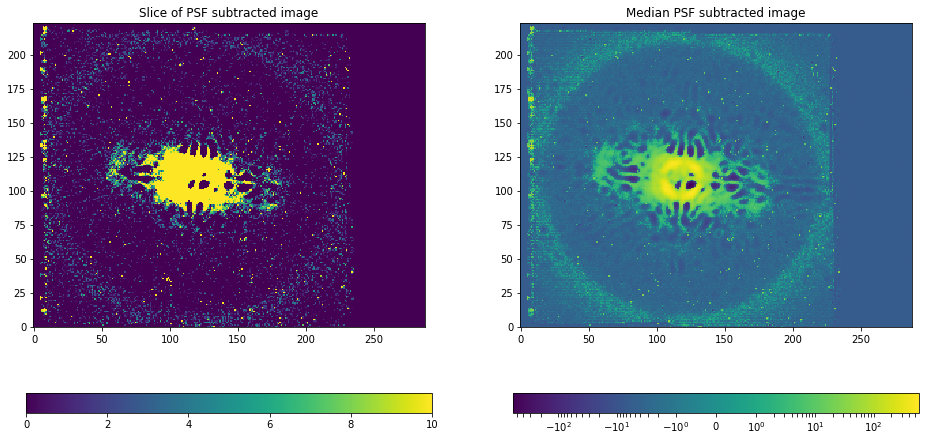

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax = axes[0]
ax.set_title("Slice of PSF subtracted image")
imax = ax.imshow(subtracted_image[50],
                 vmin = 0, vmax = 10,
                 interpolation ="none", origin='lower')
fig.colorbar(imax, ax=ax, orientation='horizontal')

ax = axes[1]
ax.set_title("Median PSF subtracted image")
imax = ax.imshow(np.median(subtracted_image, axis=0),
                 #vmin = 0, vmax = 10,
                 norm=mpl.colors.SymLogNorm(1),
                 interpolation ="none", origin='lower')
fig.colorbar(imax, ax=ax, orientation='horizontal')